Much of this content can be attributed to the work of Chris Fonnesbeck with source data found at: https://github.com/fonnesbeck/Bios8366

# 6.0 Model Development & Evaluation

### Alvin D. Jeffery, Lisianne Pruinelli, & Chris Cruz

#### 2018 Nursing Knowledge: Big Data Science Pre-Conference

#### 6/13/18

**Objectives:**  
1. Describe at least 3 modeling/machine learning techniques used in biomedical data science.  
2. Develop a machine learning model for predicting a healthcare outcome.  

### 6.1 What is Machine Learning (ML)?

Machine Learning (ML) is about coding programs that automatically adjust their performance from exposure to information encoded in data. This learning is achieved via **tunable parameters** that are automatically adjusted according to performance criteria.

Machine Learning can be considered a subfield of Artificial Intelligence (AI).

There are three major classes of ML:

**Supervised learning**: Algorithms which learn from a training set of *labeled* examples (exemplars) to generalize to the set of all possible inputs.  
Examples: regression, support vector machines

**Unsupervised learning**: Algorithms which learn from a training set of *unlableled* examples, using the features of the inputs to categorize inputs together according to some statistical criteria.  
Examples: k-means clustering, kernel density estimation

**Reinforcement learning**: Algorithms that learn via reinforcement from a *critic* that provides information on the quality of a solution, but not on how to improve it. Improved solutions are achieved by iteratively exploring the solution space.

### 6.2 Introduction to `Scikit-learn`

The `scikit-learn` package is an open-source library that provides a robust set of machine learning algorithms for Python. It is built upon the core Python scientific stack (*i.e.* NumPy, SciPy, Cython), and has a simple, consistent interface, making it useful for many data science applications.

<img src="http://1.bp.blogspot.com/-ME24ePzpzIM/UQLWTwurfXI/AAAAAAAAANw/W3EETIroA80/s1600/drop_shadows_background.png" width="90%"/>

In [68]:
# previously loaded modules 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mplot
%matplotlib inline
import IPython
from IPython.core.display import HTML
from IPython.core.debugger import set_trace
import xlrd 

In [69]:
# load scikit-learn modules
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import random as rnd
from random import random, randint

### 6.3 Representing Data in `scikit-learn`

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a
**two-dimensional array or matrix**.  The arrays can be
either ``numpy`` arrays, or in some cases ``scipy.sparse`` matrices.
The size of the array is expected to be `[n_samples, n_features]`

- **n_samples:**   The number of samples: each sample is an item to process (e.g. classify).
  A sample can be a document, a picture, a sound, a video, an astronomical object,
  a row in database or CSV file,
  or whatever you can describe with a fixed set of quantitative traits.
- **n_features:**  The number of features or distinct traits that can be used to describe each
  item in a quantitative manner.  Features are generally real-valued, but may be boolean or
  discrete-valued in some cases.

The number of features must be fixed in advance. However it can be very high dimensional
(e.g. millions of features) with most of them being zeros for a given sample. 

In [70]:
# load data created from previous steps
import os, shutil
cwd = os.getcwd()
datadir = cwd + '/data_oh'

df = pd.read_pickle(datadir + '/data_cleaned_oh.pkl')
df.head()

,pat_id,birth_date,death_date,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids,opioid_discharge_days_supply
0,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,2009-05-16,,,white,portuguese,F,Columbus,278 Green Pathway Ashland Ohio 44805 US,0,9.0,0,0,0,0
1,d78c03e8-5c27-42d4-ac6a-634136a338d9,2004-01-03,,,white,american,M,Beavercreek,211 Welch Plaza Columbus Ohio 43002 US,0,14.0,0,0,0,0
2,3eebba63-51a3-4f76-86fc-fa584f56aa87,2002-06-23,,,white,portuguese,F,Warrenship,148 Beer Common Mount Healthy Ohio 45231 US,0,16.0,0,0,0,0
3,9f8e3f49-c8ed-40ee-910c-61202baf9bff,2015-03-25,,,white,english,M,New Franklin,182 Mann Row Columbus Ohio 43002 US,1,3.0,0,0,0,0
4,09bd4fe4-bb55-427c-bd36-6d9d51ee6b01,2014-05-05,,,white,swedish,F,Columbus,149 Trantow Plaza Dayton Ohio 45377 US,0,4.0,0,0,0,0


### 6.4 Encoding Categorical Variables
Most of the models in scikit-learn require the categorical variables be turned into numeric variables.  There are two approaches to this:
1. One Hot Encoding - each item in the categorical variable is turned into its own variable represetnting the presence or abscence of that item.  For example, 'Gender' would turn into 2 variables:  'Gender_M' and 'Gender_F'
2. Label Encoding - assign an integer to each item.  For the 'Gender' variable, 0 might mean Male and 1 might mean Female.

We will use the `LabelEncoder` transformation to change categorical variables into integers.  As a convenience, we can also keep the original (human readable) variable in the Dataframe.

In [71]:
# Let's use the following variables as our initial set of predictors
cat_cols = ['gender', 'marital', 'race', 'ethnicity']
cat_cols_encoded = [c + '_encoded' for c in cat_cols]
numeric_cols = ['prior_opioid_abuse_diag', 'age', 'opioid_discharge_days_supply']
pred_cols = numeric_cols + cat_cols_encoded
target_col = 'overdose'
all_cols = cat_cols+numeric_cols+[target_col]

df_opioids = df[df['prescribed_opioids'] == 1]

# Encode the categorical variables
dfe = df_opioids[cat_cols]

# Replace missing data with an 'Unknown' category 
# so the missing data will also be encoded
dfe = dfe.replace(np.NaN,'Unknown')

# Encode the categorical variables
encoded = dfe.apply(preprocessing.LabelEncoder().fit_transform)

# Append the non-categorical variables and the encoded variables 
# into a single Dataframe
# Name the new variables as <name>_encoded
dfe = pd.concat([df_opioids[all_cols], encoded.add_suffix('_encoded')],axis=1)
display(dfe.head(2))

,gender,marital,race,ethnicity,prior_opioid_abuse_diag,age,opioid_discharge_days_supply,overdose,gender_encoded,marital_encoded,race_encoded,ethnicity_encoded
29,M,M,black,african,1,44.0,29,1,1,1,1,0
47,F,S,white,italian,0,65.0,27,1,0,2,4,13


In [72]:
# let's build a model using this set of variables...
pred_cols = ['age', 'opioid_discharge_days_supply', 
             'prior_opioid_abuse_diag', \
             'gender_encoded', 'marital_encoded', 'race_encoded', \
             'ethnicity_encoded']
#pred_cols = ['prior_abuse_diag', 'adult', 'age_at_visit', \
#             'opioid_discharge_days_supply', 'gender_encoded', \
#             'marital_encoded', 'race_encoded', 'ethnicity_encoded']

LR_pred_cols = pred_cols
X = dfe[pred_cols].as_matrix()
y = dfe['overdose'].as_matrix()
print('Using predictor variables of:',pred_cols)

Using predictor variables of: ['age', 'opioid_discharge_days_supply', 'prior_opioid_abuse_diag', 'gender_encoded', 'marital_encoded', 'race_encoded', 'ethnicity_encoded']


### 6.5 How do we approach problems from a Data Science perspective?

Imagine a set of observational (empirical data) that we want to *learn* from...  
<img src="https://www.learnopencv.com/wp-content/uploads/2017/02/data-points.png", width='60%'/>

We can fit a variety of models ranging from extremely *simple* to highly *complex* models, e.g., 
<img src='https://www.learnopencv.com/wp-content/uploads/2017/02/bias-variance-tradeoff.png' width='60%'/>

**What are potential problems with each of these cases?**

When applying these same models to a *new* set of data we held out for testing...
<img src='https://www.learnopencv.com/wp-content/uploads/2017/02/bias-variance-tradeoff-test-error.png' width='60%'/>
**We were overfit with the more complex, polynomial model.**

### Bias vs. Variance
<img src='https://www.learnopencv.com/wp-content/uploads/2017/02/Bias-Variance-Tradeoff-In-Machine-Learning-1.png' width='50%'/>

**Rule of Thumb:** Fit model complexity to the data resources (not the target complexity)  

### 6.6 Practical Approaches  
In Data Science, we tend to do the following with a data set:  
1. Learn a model based on training data (e.g., 60% of data)  
2. Iteratively modify model based on a validation set:  
    2a. Cross-validation/bootstrap with the training data  
    2b. Separate validation set (e.g., 20% of data)  
3. Estimate generalization error with a test set (e.g., 20% of data) that you only look at once  

*Food for Thought:* With small validation sets, error measure is a bad estimator of the best hypothesis.  With large validation sets, error measure is a great estimator of a terrible hypothesis.  

### 6.7 Let's Build Some Models!

Let's begin preparing our pain data for machine learning algorithms.

### How do these models work?  

#### Logistic Regression
<img src='http://www.saedsayad.com/images/LogReg_1.png' width='80%'/>

#### Linear Discriminant Analysis
<img src='http://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png' width='80%'/>

#### K-Nearest Neighbors
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png' width='30%'/>
The test sample (green circle) should be classified either to the first class of blue squares or to the second class of red triangles. If k = 3 (solid line circle) it is assigned to the second class because there are 2 triangles and only 1 square inside the inner circle. If k = 5 (dashed line circle) it is assigned to the first class (3 squares vs. 2 triangles inside the outer circle).

#### Decision Trees
<img src='https://qph.fs.quoracdn.net/main-qimg-b17755d2e0ffb326d8c39b7f3e07e03b-c' width='80%'/>

#### Random Forest
<img src='https://i.ytimg.com/vi/ajTc5y3OqSQ/hqdefault.jpg' width='65%'/>

#### Gaussian Naive Bayes
<img src='https://chrisalbon.com/images/machine_learning_flashcards/Gaussian_Naive_Bayes_Classifier_print.png' width='80%'/>

### 6.8 Let's (Really) Build Some Models! 

In [73]:
# models we'll consider
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [74]:
# Let's try a simple logistic regression model to see how predictive our data is

# perform a model fit on the training set
LR = LogisticRegression()
result = LR.fit(X, y)

# calculate predicted values from the model to compare with actual outcomes
expected = y
predicted = LR.predict(X)

print('\nClassification Report\n',metrics.classification_report(expected, predicted))
print('\nConfusion Matrix\n',metrics.confusion_matrix(expected, predicted))
print('\nAccuracy score =',metrics.accuracy_score(expected, predicted))
print('\nAUC score =',metrics.roc_auc_score(expected, predicted))
print('\nf1 score =',metrics.f1_score(expected, predicted))


Classification Report
              precision    recall  f1-score   support

          0       0.86      0.95      0.91       932
          1       0.71      0.43      0.54       249

avg / total       0.83      0.84      0.83      1181


Confusion Matrix
 [[887  45]
 [141 108]]

Accuracy score = 0.842506350550381

AUC score = 0.6927258389782306

f1 score = 0.537313432835821


### What do these numbers mean?  
According to Wikipedia:

![Confusion Matrix](images/Sensitivity-Wikipedia.png)

Precision = $\frac{tp}{tp + fp}$ ,  
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

Recall = $\frac{tp}{tp + fn}$  
The recall is intuitively the ability of the classifier to find all the positive samples.

Accuracy = $\frac{tp + tn}{N}$  

$F1 = 2 * \frac{precision * recall}{precision + recall}$  
The $F1$ score can be interpreted as a weighted average of the precision and recall, where an $F1$ score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the $F1$ score are equal. 

The support is the number of occurrences of each class in $y_{test}$.

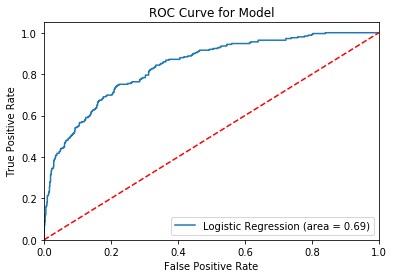

In [75]:
# Lets graph an ROC curve for the model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# we'll use the test set (rather than training) for this evaluation
auc = roc_auc_score(y, LR.predict(X))
probs = LR.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, probs)
tpr[1] = tpr[0]

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model')
plt.legend(loc="lower right")
plt.show()

# 7.0 Model Performance and Evaluation

### Goals of Performance Evaluation

* To determine the most accurate predictive model

* To determine generalizability of the model

* To prevent overlearning

* To quantify the performance of a model and how we can improve it


## Cost of Unreliable Predictive Models

- Patient Safety and Risk

- Poorer Quality and Patient Outcomes

- Time Waste (development and application)

- Financial 


## Problems to Mitigate

The model development process must strike a balance between learning too much and learning too little

* Overlearning
    * It's quite easy to create a model the "memorizes" the data
    * It perfectly fits your training data, but is useless when shown new data
    * The number of possible ways to train a model is exponential
    * Model parameters are too specific to training data
* Insufficient training data
* Inadequate data set aside for testing and cross-validation
* Application of improper model (e.g., linear model on variables with non-linear relationships).


## Dataset Partitioning

Experimental validation using an external data set is the best method of validating a model and ensuring generalizability.

* Training Dataset - used to build the model via a learning algorithm and to identify discriminating features of the predictor variables 

* Test Dataset - used to assess the prediction error of the final model

* Validation Dataset - used to assess how well the model perform against real data, to ensure stability and, in some cases, to fine-tune the model 


## Evaluating Performance

* It’s impossible to design a learning method that’s guaranteed not to overlearn¹.
* Hold aside some data to test the model (20-30%)
* The remaining portion of data (training set) will be used to create the model.
* Use a model evaluation metric to compare the performance of predictive models
    * Metrics include f-statistic, Lift, Area Under the ROC Curve (AUC), etc.

<sub>¹Siegel, E (2016). Predictive Analytics: the power to predict who will click, buy, lie or die. Wiley</sub>

### 7.1 Preventing Overfitting

- One way to prevent overfitting is to set aside some portion of the data to test with the model.  Thus the data is split into Training and Test partitions.

- We can build a Logistic Regression model that is predictive of overdose risk. But we trained the model and tested it with our entire data set, which isn't exactly a fair test of the model.

- We should split our dataset into a training dataset and a test dataset. After we train the model using just the training dataset, we will evaluate the model using the test dataset which has data that the model has never seen before.

- scikit-learn has a helpful function called train_test_split that randomly splits our dataset.


In [76]:
# Create the training and test datasets
# Partition 30% of the data to the Test set
train, test = train_test_split(dfe, test_size=0.3, random_state=987)

X_train = train[pred_cols].as_matrix()
y_train = train['overdose'].as_matrix()
X_test = test[pred_cols].as_matrix()
y_test = test['overdose'].as_matrix()

print('X_train shape = ',X_train.shape)
print('y_train shape = ',y_train.shape)
print('X_test shape = ',X_test.shape)
print('y_test shape = ',y_test.shape)

X_train shape =  (826, 7)
y_train shape =  (826,)
X_test shape =  (355, 7)
y_test shape =  (355,)


### 7.2 Training and Test Errors

- Training Error: calculated by applying the statistical learning method to the observations used in the training.

- Test Error: the average error that results from using a statistical learning method to predict the response on a new observation.


## Training vs Test Performance

The validation estimate of the test error can be highly variable, depending on precisely which observations are included in the training set and which observations are included in the validation set.

<img src='images/TrainingTestPerformance.png' width='70%'>

<sub>¹Cross-validation and bootstrap. Stanford Lagunita. Humanities Science. Statistical Learning.</sub>


### 7.3 Example: Evaluating Performance of a Decision Tree

There is always a tension (tug-of-war) between learning and overlearning. The recommended approach is to overlearn and then cut-back on the tree.

Let's create a decision tree that overlearns the data



In [82]:
# Create Decision Tree models with tree depths of 1 to 25
from sklearn.metrics import roc_curve, auc
tree_depths = np.linspace(1, 25, 25, endpoint=True)
train_auc = []
test_auc = []
for d in tree_depths:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)  # Fit a model to a tree at the current tree depth
    # Calc the false positive rate and the true positive rates by comparing the training answers to the model
    pred = dt.predict(X_train)
    # Compute the AUC from the rates and append it to the training auc data
    fpr, tpr, thresholds = roc_curve(y_train, pred)
    train_auc.append(auc(fpr, tpr))
    # Calc the false positive rate and the true positive rates by comparing the test answers to the model
    pred = dt.predict(X_test)
    # Compute the AUC from the rates and append it to the test auc data
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    test_auc.append(auc(fpr, tpr))


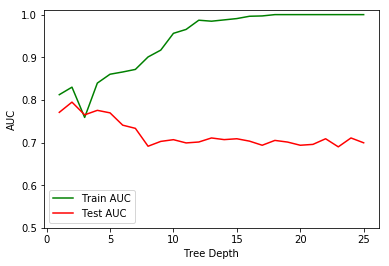

In [83]:
# Graph the AUCs of the training and test models at various tree depths
# Notice that the training scores continue to improve until they hit 1.0 (Perfect model, complete memorization)
# But the training scores get worse as the training model improves
from matplotlib import pyplot as plt
plt.plot(tree_depths, train_auc, 'g', label='Train AUC')
plt.plot(tree_depths, test_auc, 'r', label='Test AUC')
plt.legend(loc=3)
plt.ylim((0.5,1.01))
plt.ylabel('AUC')
plt.xlabel('Tree Depth')
plt.show()

### 7.4 Resampling Methods

Splitting the data into a training dataset and a test dataset has a drawback in that it doesn't allow us to train the model on all of the data.  

Two common resampling methods are k-fold cross-validation and bootstrap

- Involve repeated drawing samples from a training set and refitting a model of interest on each sample in order to obtain additional information about the fitted model and use all of the data for training while preventing overfitting

- Provide estimates for test-set prediction error, standard deviation and bias of parameter estimates


### 7.5 K-fold Cross Validation

- K-fold cross validation randomly divides the data into k equal sized subsets and then trains the model on the remaining k-1 segments of the data and tests it on the data that was held out.  
- The process is repeated k times so that in the end all of the data is used at some point to train the model.  
- The k model results are averaged to produce a single estimate of model performance.


## K-fold Cross Validation
<img src=images/kfold.png width='70%'>

                                      
A schematic display of 5-fold CV. 
A set of n observations is randomly split into five non-overlapping groups. Each of these fifths acts as a validation set (shown in beige), and the remainder as a training set (shown in blue). The test error is estimated by averaging the five resulting MSE estimates.
                                  

In [91]:
# Split the data using KFold cross validation
kfold = model_selection.KFold(n_splits=3)
data = range(0,9)
print("Data:",list(data))
for train, test in kfold.split(data):
    print("Train: ", train, 'Test:', test)

Data: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Train:  [3 4 5 6 7 8] Test: [0 1 2]
Train:  [0 1 2 6 7 8] Test: [3 4 5]
Train:  [0 1 2 3 4 5] Test: [6 7 8]


In [16]:
# Perform k-fold cross validation
LR = LogisticRegression()

result = LR.fit(X,y)
print(LR)

kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(LR, X, y, cv=kfold, scoring='roc_auc')

print('Model score = %.4f (%.4f)' %(results.mean(), results.std()))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Model score = 0.8354 (0.0304)


### 7.6 Bootstrap

Bootstrap theory says that the distance between the population mean and sample mean is similar to the distance between sample mean and bootstrap ‘subsample’ mean. 


- “To Pull Oneself up by one’s bootstraps” – Rudoph Erich Raspe

- A flexible and powerful statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method¹

- Allows us to use a computer to mimic the process of obtaining new data set without generating additional samples (sampling with replacement).

- A new model is trained on a subset of the data and uses the remaining test data to score the model.  The scores are averaged over many iterations to produce the model score.


## Bootstrap Example

A graphical illustration of the bootstrap approach on a small sample containing n = 3 observations. Each bootstrap data set contains n observations, sampled with replacement from the original data set. Each bootstrap data set is used to obtain an estimate of α¹.

![Bootstrap](images/bootstrap.png)

¹James, G., Witten, D., & Hastie, T. (2013). An introduction to statistical learning with applications in R. New York: Springer New York.

In [17]:
# Bootstrap without replacement

from sklearn import cross_validation
bootstrap = cross_validation.ShuffleSplit(10, test_size=0.3)
print(len(bootstrap))
print(bootstrap)
for train, test in bootstrap:
    print("Train: ", train, 'Test:', test)

10
ShuffleSplit(10, n_iter=10, test_size=0.3, random_state=None)
Train:  [8 6 5 9 7 1 3] Test: [4 0 2]
Train:  [0 5 6 4 8 9 2] Test: [7 3 1]
Train:  [0 8 7 5 1 4 6] Test: [2 3 9]
Train:  [1 4 8 6 5 2 7] Test: [0 3 9]
Train:  [4 2 9 7 8 1 0] Test: [5 6 3]
Train:  [3 6 5 0 2 8 1] Test: [7 9 4]
Train:  [3 7 9 0 4 8 5] Test: [2 6 1]
Train:  [9 4 5 7 2 8 0] Test: [1 3 6]
Train:  [7 6 9 2 8 5 0] Test: [4 3 1]
Train:  [7 1 3 9 8 5 0] Test: [6 2 4]


In [18]:
# Perform bootstrap (without replacement)
LR = LogisticRegression()

result = LR.fit(X,y)
print(LR)

bootstrap = model_selection.ShuffleSplit(10, test_size=0.3)
results = model_selection.cross_val_score(LR, X, y, cv=bootstrap, scoring='roc_auc')

print('Model score = %.4f (%.4f)' %(results.mean(), results.std()))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Model score = 0.8365 (0.0309)


### 7.7 Example: Tracking Hospital Acquired CDiff Infections

<img src='images/cdiff.png' width='70%'>

UCSF Analytics group used logistics regression with clustering by patient within the EHR data focusing on 86,648 hospitalizations with 434, 745 patient location changes. ED CT-Scanner met statistical significance in adjusted analyses (4%incidence rate vs overall 1.3%) 
Covariates include age, sex, antibiotic use, number of location changes, LOS, proton pump inhibitor use, inflammatory bowel disease, and prior hospitalization (within 90 days) ¹

<sub>¹Murray SG, Yim JWL, Croci R, et al. Using Spatial and Temporal Mapping to Identify Nosocomial Disease Transmission of Clostridium difficile. JAMA Intern Med. 2017;177(12):1863–1865. </sub>

# 8.0 Ok Finally, Let's Build Lots of Models! 

Now that we now how to avoid some of the predictive model building pitfalls, lets build a number of different types of models and meaasure their performance.  We will use "AUC" as our performance measure.

In [19]:
# prepare configuration for cross validation test harness 
# (from https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/)
seed = 123
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))

# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc' 
# others include: 'accuracy', 'f1', 'roc_auc', 
# or found here: http://scikit-learn.org/stable/modules/model_evaluation.html

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, 
                                                 cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.850580 (0.069428)
LDA: 0.854124 (0.071762)
KNN: 0.792670 (0.080616)
CART: 0.745872 (0.054241)
RF: 0.852983 (0.056399)
NB: 0.852054 (0.074913)


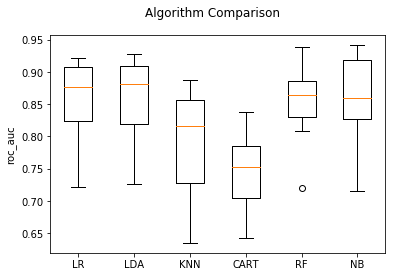

In [20]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.ylabel(scoring)
ax.set_xticklabels(names)
plt.show()

### Which model did "best"?  

We'll tackle this more in the next section on **Model Performance and Evaluation.**  

For now, just let's say *higher* is *better*.  

### *Exercise:* Look at F1 scores instead of AUC scores. 

In [21]:
# evaluate each model in turn
results = []
names = []

####### EDIT HERE #######
#scoring = 
#########################

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, 
                                                 cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.850580 (0.069428)
LDA: 0.854124 (0.071762)
KNN: 0.792670 (0.080616)
CART: 0.747412 (0.056018)
RF: 0.838814 (0.058835)
NB: 0.852054 (0.074913)


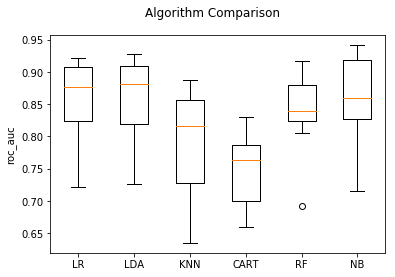

In [22]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.ylabel(scoring)
ax.set_xticklabels(names)
plt.show()

### 8.1 Hyperparameter Tuning

In [23]:
# look at the default settings you used
models

[('LR',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)),
 ('LDA',
  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                solver='svd', store_covariance=False, tol=0.0001)),
 ('KNN',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform')),
 ('CART',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best')),
 ('RF',


### *Exercise:* Attempt parameter tuning on your own



In [24]:
# use Logistic Regression & Random Forests 
models = []

####### EDIT HERE #######
#models.append(('LR', LogisticRegression()))
#models.append(('RF', RandomForestClassifier()))
#########################

# evaluate each model in turn
results = []
names = []

####### EDIT HERE #######
#scoring = 
#########################

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, 
                                                 cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

### scikit-learn can help with parameter tuning

In [25]:
### automated grid search
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'n_estimators': [50, 100, 250], 
         'class_weight': [None, 'balanced'], 
         'max_features': [2, 'sqrt', None]}
]

rfc = RandomForestClassifier()
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
cvres = grid_search.cv_results_

In [26]:
# print results
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(np.sqrt(mean_score), 3), params)

0.795 {'class_weight': None, 'max_features': 2, 'n_estimators': 50}
0.776 {'class_weight': None, 'max_features': 2, 'n_estimators': 100}
0.776 {'class_weight': None, 'max_features': 2, 'n_estimators': 250}
0.762 {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 50}
0.778 {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100}
0.783 {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 250}
0.798 {'class_weight': None, 'max_features': None, 'n_estimators': 50}
0.789 {'class_weight': None, 'max_features': None, 'n_estimators': 100}
0.8 {'class_weight': None, 'max_features': None, 'n_estimators': 250}
0.779 {'class_weight': 'balanced', 'max_features': 2, 'n_estimators': 50}
0.788 {'class_weight': 'balanced', 'max_features': 2, 'n_estimators': 100}
0.772 {'class_weight': 'balanced', 'max_features': 2, 'n_estimators': 250}
0.779 {'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 50}
0.79 {'class_weight': 'balanced', 'max_features': 'sqrt',

### 8.2 Finalizing the Model

In [27]:
# assign parameters from best fit
final_fit = RandomForestClassifier(class_weight=None, 
                                   max_features=2, 
                                   n_estimators=100)

final_fit.fit(X_train, y_train)

# store predicted values using the final model
pred_train = final_fit.predict(X_train)
pred_test = final_fit.predict(X_test)

In [28]:
# explore performance on training data
pd.crosstab(y_train, pred_train, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,664,0
1,0,162


In [29]:
# explore performance on testing data
pd.crosstab(y_test, pred_test, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,240,28
1,39,48


In [30]:
# Show how to use the resulting model to predict opioid overdose
# age, opioid_discharge_days_supply, prior_opioid_abuse_diag, 
# gender (F), marital (M), race (white), ethnicity (english)
new_patient = [45,10,1,0,1,4,7]

pred = final_fit.predict(np.asmatrix(new_patient))
if pred[0] == 0:
    print('Patient has no overdose risk.')
elif pred[0] == 1:
    print('Patient has overdose risk.')

Patient has overdose risk.


---
## References

- [`scikit-learn` user's guide](http://scikit-learn.org/stable/user_guide.html)
- Vanderplas, J. (2016) [Python Data Science Handbook: Essential Tools for Working with Data](http://shop.oreilly.com/product/0636920034919.do). O'Reilly Media.